<a href="https://colab.research.google.com/github/Makovyova/Intelligent-Systems/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи


**Цель работы:** Реализовать pipeline сжатия изображений через YCbCr, субдискретизацию 4:2:0 и квантование с оценкой качества.

**Подробнее:**
Упрощенный алгоритм сжатия изображений (аналог JPEG)

# Данные

Размер изображения: (2888, 2888, 3)


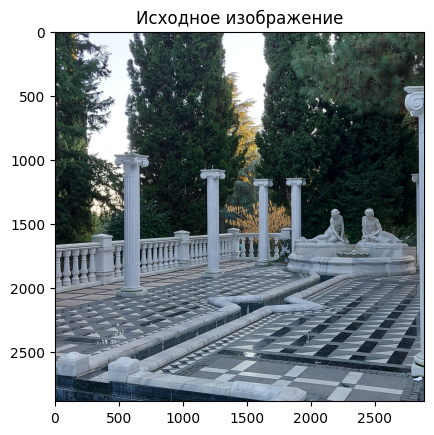

In [ ]:

# Вариант загрузки данных (это если по ссылке)
#!wget https://your_image_url.jpg
#!wget https://drive.google.com/uc?id=1-dq_strdSbMKIAAf6FNf5rjIQ1UB-rSR

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Загрузка изображения (из папки src, тут же)
image_path = "/content/src/20210103_161604.jpg"
image = np.array(Image.open(image_path))
print("Размер изображения:", image.shape)
# Загрузка изображения (по ссылке на гугл драйв)
#url = "https://drive.google.com/uc?id=1-dq_strdSbMKIAAf6FNf5rjIQ1UB-rSR"
#response=requests.get(url)
#img_data = response.content
#image = Image.open(BytesIO(img_data))

plt.imshow(image)
plt.title("Исходное изображение")
plt.show()


# JPEG сжатие

## Подготовка данных

Формулы для перевода RGB в формат YCbCr. В этом формате Y представляет собой картинку в градациях серого (grayscale):
$$Y = 0.299 • R + 0.587 • G + 0.114 • B$$

$$Cb = -0.1687 • R - 0.3313 • G + 0.5 • B + 128$$

$$Cr = 0.5 • R - 0.4187 • G - 0.0813 • B + 128$$

Конвертация в YCbCr

In [ ]:
def rgb_to_ycbcr(image):
    y = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
    cb = -0.1687 * image[:,:,0] - 0.3313 * image[:,:,1] + 0.5 * image[:,:,2] + 128
    cr = 0.5 * image[:,:,0] - 0.4187 * image[:,:,1] - 0.0813 * image[:,:,2] + 128
    return np.stack([y, cb, cr], axis=2)

ycbcr = rgb_to_ycbcr(image)

## Субдискретизация 4:2:0

<img src="https://drive.google.com/uc?id=1-dq_strdSbMKIAAf6FNf5rjIQ1UB-rSR" alt="subdiscr 4:2:0" width="300" height="320">

## Квантование

In [ ]:
def quantize(channel, step):
    return (channel // step) * step + step / 2

step_y = 4  # Шаг квантования для Y
step_c = 8  # Шаг квантования для Cb/Cr (больше = сильнее сжатие)

y_quantized = quantize(ycbcr[:,:,0], step_y)
cb_quantized = quantize(cb_subsampled, step_c)
cr_quantized = quantize(cr_subsampled, step_c)

## Восстановление изображения

Чтобы снова перейти от формата YCbCr к RGB, нужно восстановить цветоразностные каналы, а затем сделать пересчет по формулам:

$$R = Y + 1.402 • (Cr − 128)$$

$$G = Y − 0.34414 • (Cb − 128) − 0.71414 • (Cr − 128)$$

$$B = Y + 1.772 • (Cb − 128)$$

In [ ]:
def upsample_420(channel, original_shape):
    # Линейная интерполяция для увеличения в 2 раза
    from scipy.ndimage import zoom
    return zoom(channel, zoom=(original_shape[0]/channel.shape[0],
                                original_shape[1]/channel.shape[1]))

cb_restored = upsample_420(cb_quantized, ycbcr.shape[:2])
cr_restored = upsample_420(cr_quantized, ycbcr.shape[:2])

# Обратное преобразование YCbCr → RGB
def ycbcr_to_rgb(y, cb, cr):
    r = y + 1.402 * (cr - 128)
    g = y - 0.34414 * (cb - 128) - 0.71414 * (cr - 128)
    b = y + 1.772 * (cb - 128)
    return np.clip(np.stack([r, g, b], axis=2), 0, 255).astype(np.uint8)

restored_image = ycbcr_to_rgb(y_quantized, cb_restored, cr_restored)

## Оценка качества

MSE и ее модификация RMSE (корень квадратный из MSE) – метрики, часто использующиеся в разных областях. В частности, их используют в статистике и машинном обучении для оценки качества регрессионной модели.

$$MSE =  \frac{1}{\ell} \sum\limits_{i=1}^\ell (\hat y_{i}  - y_{i})^2 $$

Здесь $\ell$ – количество пикселей в картинке (и в исходной, и после обработки), $\hat y_{i}$  и $y_{i}$ – яркости пикселей в исходной картинке и в картинке после обработки.

Степень сжатия рассчитывается по формуле:

$$C = \frac{H_y}{H_{\hat y}}$$

$H_y$ – это среднее количество бит на один пиксель в исходном изображении. В этом задании это должно быть 24 бита.

$H_{\hat y}$ – это оценка среднего количества бит на один пиксель в изображении после обработки.


Энтропия Шеннона для системы с $N$ возможными состояниями определяется по формуле:

$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

In [ ]:
def calculate_metrics(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    rmse = np.sqrt(mse)
    psnr = 20 * np.log10(255 / rmse)
    return mse, rmse, psnr

mse, rmse, psnr = calculate_metrics(image, restored_image)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, PSNR: {psnr:.2f} dB")

MSE: 12.09, RMSE: 3.48, PSNR: 37.31 dB


##  Визуализация результатов

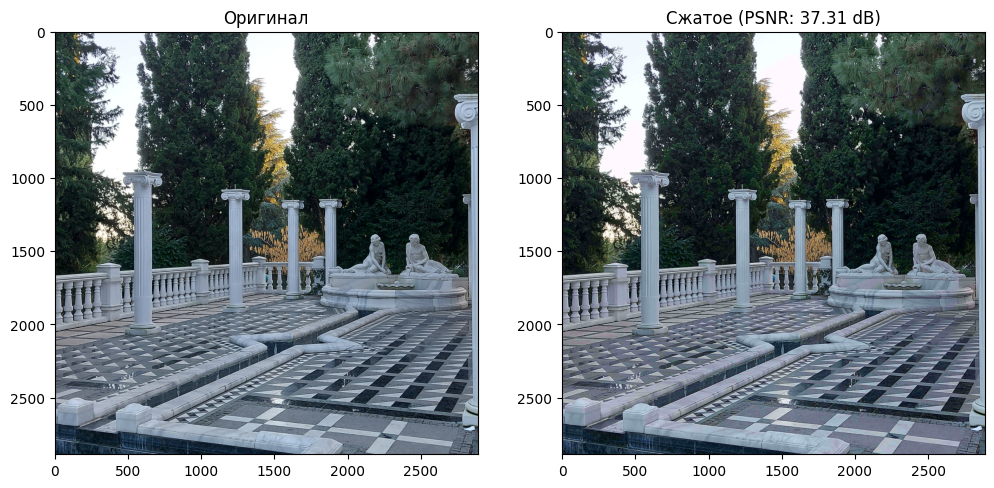

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Оригинал")
plt.subplot(1, 2, 2)
plt.imshow(restored_image)
plt.title(f"Сжатое (PSNR: {psnr:.2f} dB)")
plt.show()

# CNN-based сжатие

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models

Добавить изображение + предобработка?

# Autoencoder сжатие